<a href="https://colab.research.google.com/github/relativity-1c/relativity-1c/blob/main/Change_of_Venue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Change of Venue in Legal Evidence Prediction

The aim of this notebook is to create a prototype of a sentiment analysis model to analyze textual evidence and detect if a potentially suspicious "change of venue" is taking place -- e.g. switching from online to offline communication to hide harmful activities such as bribery or fraud. The following steps are included:

1. A prompting function to Gemini to generate examples and non-examples of such communications to use as a predictor dataset.
2. A function instructing Gemini on how to analyze evidence, and calling it on the above examples to detect potentially harmful change of venue.
3. Metrics on the performance of the above model.


### Function to generate example evidence using Gemini.


In [ ]:
import requests
import json
import google.generativeai as genai
import pandas as pd

import requests
from google.colab import userdata
key = userdata.get('gemini-api-key')
genai.configure(api_key=key)


def geminiSynthesis(num_phrases):
    model = genai.GenerativeModel("gemini-1.5-pro-latest")
    data = []


    prompt = f"""Generate the FIRST HALF({num_phrases}/2) examples of communications where people are trying to switch the mode
    of communication to conceal potentially unethical activities, such as fraud or bribery. Each example should be a single
    paragraph conversation that subtly implies the change is for discretion.

    AND, make sure to also generate the SECOND HALF ({num_phrases}/2) non examples,
    so we can then build a classifier for detecting the signal above.

    Output each example in the following JSON structure:

    {{
    "examples": [
        {{
            "conversation": "Full conversation text as a single paragraph.",
            "mode_change": "Original mode of communication to the suggested mode, e.g., 'Text to In-Person Meeting' OR
            None if not an example of a suspicious switch of mode"
        }},
        // Repeat for a total of 10 examples
    ]
    }}"""

    response = model.generate_content(prompt)
    print(response)
    try:
            candidates = response.candidates
            if candidates:
                content = candidates[0].content.parts[0].text.strip('```json\n')

                #Parsing the content as JSON
                result_dict = json.loads(content)

                examples = result_dict.get("examples", [])
                print(examples)

                #Iterating over each example and extract relevant data
                for example in examples:
                  conversation = example.get("conversation", "")
                  mode_change = example.get("mode_change", "")
                  data.append({
                    "conversation": conversation,
                    "mode_change": mode_change,
                  })
                print(data)



    except (json.JSONDecodeError, KeyError, AttributeError) as e:
        print(f"Error generating: {e}")

    return pd.DataFrame(data)


In [ ]:
url = "https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash-latest:generateContent"
request_payload = {
    "contents": [
        {
            "parts": [{
                "text": """Generate the 50 examples of communications where people are trying to switch the mode
                of communication to conceal potentially unethical activities, such as fraud or bribery. Each example should be a single
                paragraph conversation that subtly implies the change is for discretion.

                AND, make sure to also generate 50 non examples,
                so we can then build a classifier for detecting the signal above.

                Output each example in the following JSON structure:

                {{
                "total_examples": [
                    {{
                        "conversation": "Full conversation text as a single paragraph.",
                        "mode_change": "Original mode of communication to the suggested mode, e.g., 'Text to In-Person Meeting' OR
                        None if not an example of a suspicious switch of mode"
                    }}
                ]
                }}
                """
            }]
        }
    ]
}

response = requests.post(url, json=request_payload, params={"key": key})
response.raise_for_status()

response_dict = response.json()

completion = response_dict["candidates"][0]["content"]["parts"][0]["text"].strip('```').strip('json')

print(completion)


{
  "total_examples": [
    {"conversation": "This email's getting too long. Can we hop on a quick call to discuss the final figures? I have some concerns about sending sensitive information electronically.", "mode_change": "Email to Phone Call"},
    {"conversation": "I'd rather not discuss this over email. It's more sensitive than I initially thought.  Could we meet for coffee later this week?", "mode_change": "Email to In-Person Meeting"},
    {"conversation": "Let's move this conversation offline. It's easier to have a private discussion in person, especially given the details.", "mode_change": "Email/Text to In-Person Meeting"},
    {"conversation": "Sending this over email feels risky.  Would you prefer a secure messaging app, like Signal, for this particular matter?", "mode_change": "Email to Secure Messaging App"},
    {"conversation": "This document contains confidential material. I'd feel more comfortable handing you a physical copy in person.", "mode_change": "Email to In-P

In [ ]:
data_save = {
  "total_examples": [
    {"conversation": "This email's getting too long. Can we hop on a quick call to discuss the final figures? I have some concerns about sending sensitive information electronically.", "mode_change": "Email to Phone Call"},
    {"conversation": "I'd rather not discuss this over email. It's more sensitive than I initially thought.  Could we meet for coffee later this week?", "mode_change": "Email to In-Person Meeting"},
    {"conversation": "Let's move this conversation offline. It's easier to have a private discussion in person, especially given the details.", "mode_change": "Email/Text to In-Person Meeting"},
    {"conversation": "Sending this over email feels risky.  Would you prefer a secure messaging app, like Signal, for this particular matter?", "mode_change": "Email to Secure Messaging App"},
    {"conversation": "This document contains confidential material. I'd feel more comfortable handing you a physical copy in person.", "mode_change": "Email to In-Person Handover"},
    {"conversation": "I'm uncomfortable putting these terms in writing. Can we chat on the phone so we can both clarify our understanding?", "mode_change": "Email to Phone Call"},
    {"conversation": "Given the complexity, email is not the ideal platform for a detailed discussion. Would a quick video call be alright?", "mode_change": "Email to Video Call"},
    {"conversation": "It's easier to explain this face-to-face. Let's schedule a meeting tomorrow morning.", "mode_change": "Email/Text to In-Person Meeting"},
    {"conversation": "I want to ensure complete confidentiality. Could we discuss this privately, maybe during a walk after work?", "mode_change": "Email/Text to In-Person Meeting (Informal Setting)"},
    {"conversation": "Email trails can be problematic.  Let's talk briefly on the phone, and I’ll get this resolved.", "mode_change": "Email to Phone Call"},
    {"conversation": "This is a little delicate.  Perhaps we can discuss this over a private lunch next week?", "mode_change": "Email/Text to In-Person Meeting (Informal Setting)"},
    {"conversation": "I think it would be better to discuss the proposal details verbally.  Let's arrange a short phone call.", "mode_change": "Email to Phone Call"},
    {"conversation": "The detail's a little too sensitive for email.  How about we chat on the phone later today?", "mode_change": "Email to Phone Call"},
    {"conversation": "To maintain discretion, let's discuss this privately in my office.", "mode_change": "Email/Text to In-Person Meeting"},
    {"conversation": "For security reasons, I'd prefer not to send this information electronically.  Can we meet tomorrow?", "mode_change": "Email to In-Person Meeting"},
    {"conversation": "Given the nature of the information, a verbal agreement would be preferable to a written one.  Let's schedule a call.", "mode_change": "Email to Phone Call"},
    {"conversation": "I'd feel more secure discussing this via encrypted messaging.  Is Signal okay?", "mode_change": "Email to Secure Messaging App"},
    {"conversation": "This requires more nuanced discussion than email allows.  Let's schedule a brief meeting.", "mode_change": "Email to In-Person Meeting"},
    {"conversation": "I'm concerned about data security.  Can we discuss this confidentially, perhaps in person?", "mode_change": "Email to In-Person Meeting"},
    {"conversation": "This needs a more personal touch. Let's have a quick phone call.", "mode_change": "Email/Text to Phone Call"},
    {"conversation": "I think a face-to-face meeting would be more efficient and confidential.  What time works for you?", "mode_change": "Email/Text to In-Person Meeting"},
    {"conversation": "To avoid any misunderstandings, let's have a quick phone call to go over the details.", "mode_change": "Email to Phone Call"},
    {"conversation": "For reasons of privacy, I'd prefer we discuss this offline.", "mode_change": "Email/Text to In-Person Meeting/Phone Call"},
    {"conversation": "This is a bit complicated to explain in an email.  Let's talk privately, maybe over a coffee?", "mode_change": "Email/Text to In-Person Meeting (Informal Setting)"},
    {"conversation": "I’m not comfortable disclosing this via email.  A short phone call would be safer.", "mode_change": "Email to Phone Call"},
    {"conversation": "To ensure clarity and confidentiality, let's set up a quick video conference.", "mode_change": "Email to Video Call"},
    {"conversation": "Email isn't secure enough for this level of detail.  Let's meet in person.", "mode_change": "Email to In-Person Meeting"},
    {"conversation": "For complete discretion, it's best we discuss this outside of email.  What's your availability?", "mode_change": "Email to Phone Call/In-Person Meeting"},
    {"conversation": "This requires a more confidential conversation. Could we have a private chat?", "mode_change": "Email/Text to Phone Call/In-Person Meeting"},
    {"conversation": "I'm concerned about the security of this information via email.  Let's schedule a private call.", "mode_change": "Email to Phone Call"},
    {"conversation": "Given the sensitivity of this, a face-to-face meeting is preferred.  Let’s meet tomorrow morning.", "mode_change": "Email/Text to In-Person Meeting"},
    {"conversation": "Email's too risky for this. We need to talk privately.  Can we meet for lunch?", "mode_change": "Email to In-Person Meeting (Informal Setting)"},
    {"conversation": "I want to ensure complete privacy.  Let's discuss this over a secure call.", "mode_change": "Email/Text to Encrypted Phone Call"},
    {"conversation": "This needs a more personal conversation.  A quick phone call would suffice.", "mode_change": "Email/Text to Phone Call"},


    {"conversation": "I've attached the document. Let me know if you have any questions.", "mode_change": "None"},
    {"conversation": "Thanks for the email. I'll get back to you by the end of the day.", "mode_change": "None"},
    {"conversation": "Looking forward to our meeting tomorrow morning. Please arrive promptly.", "mode_change": "None"},
    {"conversation": "The project is progressing well.  We're on track to meet the deadline.", "mode_change": "None"},
    {"conversation": "I'll send you a follow-up email with the revised budget.", "mode_change": "None"},
    {"conversation": "Please review the attached documents and provide your feedback.", "mode_change": "None"},
    {"conversation": "The conference call is scheduled for 2 PM tomorrow.  Please join promptly.", "mode_change": "None"},
    {"conversation": "We need to discuss this further.  Let's schedule a meeting.", "mode_change": "None"},
    {"conversation": "I've updated the spreadsheet with the latest figures.", "mode_change": "None"},
    {"conversation": "This is a reminder about our upcoming presentation.  Please prepare your slides.", "mode_change": "None"},
    {"conversation": "Thank you for your prompt response.  I appreciate your cooperation.", "mode_change": "None"},
    {"conversation": "I've sent you the invoice.  Please remit payment within 30 days.", "mode_change": "None"},
    {"conversation": "The client is satisfied with the project outcome. We can proceed to the next phase.", "mode_change": "None"},
    {"conversation": "The team is working diligently on the new product launch.", "mode_change": "None"},
    {"conversation": "We're planning a team-building event next month.  More details to follow.", "mode_change": "None"},
    {"conversation": "I'll send you the meeting minutes later today.", "mode_change": "None"},
    {"conversation": "Please submit your expense reports by the end of the week.", "mode_change": "None"},
    {"conversation": "The training session will be held in the conference room.", "mode_change": "None"},
    {"conversation": "I'll be out of the office until next week. Please contact my colleague in the meantime.", "mode_change": "None"},
    {"conversation": "We had a productive meeting with the stakeholders today.", "mode_change": "None"},
    {"conversation": "The marketing campaign is performing well.  We're seeing positive results.", "mode_change": "None"},
    {"conversation": "The new software is scheduled for rollout next month.", "mode_change": "None"},
    {"conversation": "I'll keep you updated on the progress of the project.", "mode_change": "None"},
    {"conversation": "Please let me know if you require any further assistance.", "mode_change": "None"},
    {"conversation": "We're making good progress on the project.  We're ahead of schedule.", "mode_change": "None"},
    {"conversation": "The client feedback has been overwhelmingly positive.", "mode_change": "None"},
    {"conversation": "We're exploring new opportunities to expand our business.", "mode_change": "None"},
    {"conversation": "The team is celebrating a successful project completion.", "mode_change": "None"},
    {"conversation": "We're looking forward to collaborating with you on this project.", "mode_change": "None"},
    {"conversation": "The annual report is now available on the company website.", "mode_change": "None"},
    {"conversation": "The budget is approved. We can now proceed with the project.", "mode_change": "None"},
    {"conversation": "The contract is finalized.  We can now start the project.", "mode_change": "None"},
    {"conversation": "We're pleased to announce the launch of our new product.", "mode_change": "None"},
    {"conversation": "The company is committed to ethical and transparent practices.", "mode_change": "None"},
    {"conversation": "We're always striving to improve our customer service.", "mode_change": "None"},
    {"conversation": "We value your feedback and appreciate your business.", "mode_change": "None"}
  ]
}

conversations_df = pd.DataFrame(data_save['total_examples'])
conversations_df.head()

,conversation,mode_change
0,This email's getting too long. Can we hop on a...,Email to Phone Call
1,I'd rather not discuss this over email. It's m...,Email to In-Person Meeting
2,Let's move this conversation offline. It's eas...,Email/Text to In-Person Meeting
3,Sending this over email feels risky. Would yo...,Email to Secure Messaging App
4,This document contains confidential material. ...,Email to In-Person Handover


In [ ]:
#Checking that the appropriate number of examples and non examples were generated
conversations_df.shape

(70, 2)

In [ ]:
#creating a binary column for later analysis
conversations_df['mode_change_binary'] = conversations_df['mode_change'].apply(lambda x: 0 if x == "None" else 1)
conversations_df = conversations_df.sample(frac = 1)
conversations_df

,conversation,mode_change,mode_change_binary
5,I'm uncomfortable putting these terms in writi...,Email to Phone Call,1
43,This is a reminder about our upcoming presenta...,None,0
68,We're always striving to improve our customer ...,None,0
48,We're planning a team-building event next mont...,None,0
42,I've updated the spreadsheet with the latest f...,None,0
...,...,...,...
19,This needs a more personal touch. Let's have a...,Email/Text to Phone Call,1
36,Looking forward to our meeting tomorrow mornin...,None,0
38,I'll send you a follow-up email with the revis...,None,0
45,I've sent you the invoice. Please remit payme...,None,0


### Function to prompt Gemini to perform analysis and detect suspicious change of venue in given conversations.

In [ ]:
def detectChangeOfVenue(phrases):
  #Set up data dict
  data = []
  model = genai.GenerativeModel("gemini-1.5-pro-latest")

  #Gemini iteratively classifies a phrase

  prompt = f"""Using the rubric below, classify the following conversations as whether
  they are trying to switch the mode of communication to conceal potentially unethical activities,
  such as fraud or bribery.:

  {phrases}

  The output structure should be in the following JSON format, and nothing else should be given:

  Rubric for Switch of Mode:
  1 = mode of communication switched to potentially conceal unethical activities
  0 = otherwise

  {{
    original text: <original conversation here>, change_of_venue: <switch of mode>, argument_why: Explain what about the conversation makes you choose as you did.
  }}"""

  response = model.generate_content(prompt)

  try:
    candidates = response.candidates
    if candidates:
      content = candidates[0].content.parts[0].text.strip('```json\n')
      #Parsing the content as JSON
      result_dict = json.loads(content)

      return pd.DataFrame(result_dict)
  except (requests.exceptions.RequestException, json.JSONDecodeError) as e:
    print(f"Error processing phrase: {e}")



In [ ]:
#checking the conversations list
conversations = conversations_df["conversation"].tolist()
len(conversations)

70

In [ ]:
#calling the detection function on the generated conversations
df_predictions = detectChangeOfVenue(conversations[0:10])
df_predictions

,original_text,change_of_venue,argument_why
0,I'm uncomfortable putting these terms in writi...,1,Expressing discomfort with written documentati...
1,This is a reminder about our upcoming presenta...,0,A standard professional communication regardin...
2,We're always striving to improve our customer ...,0,A general statement about customer service. No...
3,We're planning a team-building event next mont...,0,A standard announcement. No suggestion of chan...
4,I've updated the spreadsheet with the latest f...,0,A standard update about work progress. No sug...
5,I'd feel more secure discussing this via encry...,1,"While encrypted messaging can be legitimate, t..."
6,The training session will be held in the confe...,0,A standard logistical announcement. No suggest...
7,The conference call is scheduled for 2 PM tomo...,0,Standard meeting notification. No suggestion o...
8,"Given the nature of the information, a verbal ...",1,Explicitly stating a preference for verbal agr...
9,We're pleased to announce the launch of our ne...,0,A standard product announcement. No suggestio...


In [ ]:
df_predictions2 = detectChangeOfVenue(conversations[10:20])
df_predictions = pd.concat([df_predictions, df_predictions2])
df_predictions

,original_text,change_of_venue,argument_why,original text
0,I'm uncomfortable putting these terms in writi...,1,Expressing discomfort with written documentati...,NaN
1,This is a reminder about our upcoming presenta...,0,A standard professional communication regardin...,NaN
2,We're always striving to improve our customer ...,0,A general statement about customer service. No...,NaN
3,We're planning a team-building event next mont...,0,A standard announcement. No suggestion of chan...,NaN
4,I've updated the spreadsheet with the latest f...,0,A standard update about work progress. No sug...,NaN
5,I'd feel more secure discussing this via encry...,1,"While encrypted messaging can be legitimate, t...",NaN
6,The training session will be held in the confe...,0,A standard logistical announcement. No suggest...,NaN
7,The conference call is scheduled for 2 PM tomo...,0,Standard meeting notification. No suggestion o...,NaN
8,"Given the nature of the information, a verbal ...",1,Explicitly stating a preference for verbal agr...,NaN
9,We're pleased to announce the launch of our ne...,0,A standard product announcement. No suggestio...,NaN


In [ ]:
df_predictions2 = detectChangeOfVenue(conversations[20:30])
df_predictions = pd.concat([df_predictions, df_predictions2])
df_predictions

,original_text,change_of_venue,argument_why,original text
0,I'm uncomfortable putting these terms in writi...,1,Expressing discomfort with written documentati...,NaN
1,This is a reminder about our upcoming presenta...,0,A standard professional communication regardin...,NaN
2,We're always striving to improve our customer ...,0,A general statement about customer service. No...,NaN
3,We're planning a team-building event next mont...,0,A standard announcement. No suggestion of chan...,NaN
4,I've updated the spreadsheet with the latest f...,0,A standard update about work progress. No sug...,NaN
5,I'd feel more secure discussing this via encry...,1,"While encrypted messaging can be legitimate, t...",NaN
6,The training session will be held in the confe...,0,A standard logistical announcement. No suggest...,NaN
7,The conference call is scheduled for 2 PM tomo...,0,Standard meeting notification. No suggestion o...,NaN
8,"Given the nature of the information, a verbal ...",1,Explicitly stating a preference for verbal agr...,NaN
9,We're pleased to announce the launch of our ne...,0,A standard product announcement. No suggestio...,NaN


In [ ]:
df_predictions2 = detectChangeOfVenue(conversations[30:40])
df_predictions = pd.concat([df_predictions, df_predictions2])
df_predictions

,original_text,change_of_venue,argument_why,original text
0,I'm uncomfortable putting these terms in writi...,1,Expressing discomfort with written documentati...,NaN
1,This is a reminder about our upcoming presenta...,0,A standard professional communication regardin...,NaN
2,We're always striving to improve our customer ...,0,A general statement about customer service. No...,NaN
3,We're planning a team-building event next mont...,0,A standard announcement. No suggestion of chan...,NaN
4,I've updated the spreadsheet with the latest f...,0,A standard update about work progress. No sug...,NaN
5,I'd feel more secure discussing this via encry...,1,"While encrypted messaging can be legitimate, t...",NaN
6,The training session will be held in the confe...,0,A standard logistical announcement. No suggest...,NaN
7,The conference call is scheduled for 2 PM tomo...,0,Standard meeting notification. No suggestion o...,NaN
8,"Given the nature of the information, a verbal ...",1,Explicitly stating a preference for verbal agr...,NaN
9,We're pleased to announce the launch of our ne...,0,A standard product announcement. No suggestio...,NaN


In [ ]:
df_predictions2 = detectChangeOfVenue(conversations[40:50])
df_predictions = pd.concat([df_predictions, df_predictions2])
df_predictions

,original_text,change_of_venue,argument_why,original text
0,I'm uncomfortable putting these terms in writi...,1,Expressing discomfort with written documentati...,NaN
1,This is a reminder about our upcoming presenta...,0,A standard professional communication regardin...,NaN
2,We're always striving to improve our customer ...,0,A general statement about customer service. No...,NaN
3,We're planning a team-building event next mont...,0,A standard announcement. No suggestion of chan...,NaN
4,I've updated the spreadsheet with the latest f...,0,A standard update about work progress. No sug...,NaN
5,I'd feel more secure discussing this via encry...,1,"While encrypted messaging can be legitimate, t...",NaN
6,The training session will be held in the confe...,0,A standard logistical announcement. No suggest...,NaN
7,The conference call is scheduled for 2 PM tomo...,0,Standard meeting notification. No suggestion o...,NaN
8,"Given the nature of the information, a verbal ...",1,Explicitly stating a preference for verbal agr...,NaN
9,We're pleased to announce the launch of our ne...,0,A standard product announcement. No suggestio...,NaN


In [ ]:
df_predictions2 = detectChangeOfVenue(conversations[50:60])
df_predictions = pd.concat([df_predictions, df_predictions2])
df_predictions

,original_text,change_of_venue,argument_why,original text
0,I'm uncomfortable putting these terms in writi...,1,Expressing discomfort with written documentati...,NaN
1,This is a reminder about our upcoming presenta...,0,A standard professional communication regardin...,NaN
2,We're always striving to improve our customer ...,0,A general statement about customer service. No...,NaN
3,We're planning a team-building event next mont...,0,A standard announcement. No suggestion of chan...,NaN
4,I've updated the spreadsheet with the latest f...,0,A standard update about work progress. No sug...,NaN
5,I'd feel more secure discussing this via encry...,1,"While encrypted messaging can be legitimate, t...",NaN
6,The training session will be held in the confe...,0,A standard logistical announcement. No suggest...,NaN
7,The conference call is scheduled for 2 PM tomo...,0,Standard meeting notification. No suggestion o...,NaN
8,"Given the nature of the information, a verbal ...",1,Explicitly stating a preference for verbal agr...,NaN
9,We're pleased to announce the launch of our ne...,0,A standard product announcement. No suggestio...,NaN


In [ ]:
df_predictions2 = detectChangeOfVenue(conversations[60:70])
df_predictions = pd.concat([df_predictions, df_predictions2])
df_predictions

,original_text,change_of_venue,argument_why,original text
0,I'm uncomfortable putting these terms in writi...,1,Expressing discomfort with written documentati...,NaN
1,This is a reminder about our upcoming presenta...,0,A standard professional communication regardin...,NaN
2,We're always striving to improve our customer ...,0,A general statement about customer service. No...,NaN
3,We're planning a team-building event next mont...,0,A standard announcement. No suggestion of chan...,NaN
4,I've updated the spreadsheet with the latest f...,0,A standard update about work progress. No sug...,NaN
...,...,...,...,...
5,This needs a more personal touch. Let's have a...,1,Vague justifications for switching to a less d...,NaN
6,Looking forward to our meeting tomorrow mornin...,0,This is a standard meeting reminder and doesn'...,NaN
7,I'll send you a follow-up email with the revis...,0,This is a standard business communication rega...,NaN
8,I've sent you the invoice. Please remit payme...,0,This is a standard invoice communication and d...,NaN


### Metrics on the model's performance.



In [ ]:
df_predictions_fixed = df_predictions.copy()
df_predictions_fixed['original_text'] = df_predictions_fixed['original_text'].combine_first(df_predictions_fixed['original text'])

df_predictions_fixed.drop(columns=['original text'], inplace=True)
df_predictions_fixed

,original_text,change_of_venue,argument_why
0,I'm uncomfortable putting these terms in writi...,1,Expressing discomfort with written documentati...
1,This is a reminder about our upcoming presenta...,0,A standard professional communication regardin...
2,We're always striving to improve our customer ...,0,A general statement about customer service. No...
3,We're planning a team-building event next mont...,0,A standard announcement. No suggestion of chan...
4,I've updated the spreadsheet with the latest f...,0,A standard update about work progress. No sug...
...,...,...,...
5,This needs a more personal touch. Let's have a...,1,Vague justifications for switching to a less d...
6,Looking forward to our meeting tomorrow mornin...,0,This is a standard meeting reminder and doesn'...
7,I'll send you a follow-up email with the revis...,0,This is a standard business communication rega...
8,I've sent you the invoice. Please remit payme...,0,This is a standard invoice communication and d...


#### Confusion Matrix

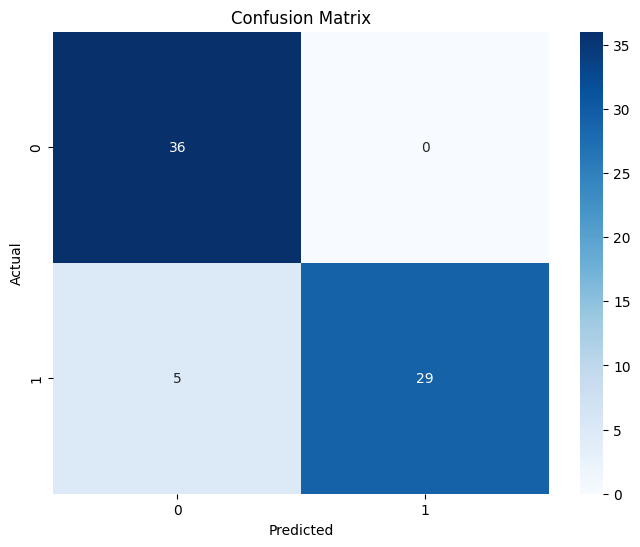

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

confusion_matrix = pd.crosstab(
    conversations_df['mode_change_binary'].reset_index(drop=True),
    df_predictions['change_of_venue'].reset_index(drop=True),
    rownames=['Actual'],
    colnames=['Predicted']
)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

#### Scores Report

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report
print("\nPer-Class Classification Report:")
print(classification_report(conversations_df['mode_change_binary'], df_predictions_fixed['change_of_venue']))


Per-Class Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.94        36
           1       1.00      0.85      0.92        34

    accuracy                           0.93        70
   macro avg       0.94      0.93      0.93        70
weighted avg       0.94      0.93      0.93        70



#### Accuracy, Precision, Recall, and F1

In [ ]:
accuracy_binary = accuracy_score(conversations_df['mode_change_binary'], df_predictions['change_of_venue'])
precision_binary = precision_score(conversations_df['mode_change_binary'], df_predictions['change_of_venue'])
recall_binary = recall_score(conversations_df['mode_change_binary'], df_predictions['change_of_venue'])
f1_binary = f1_score(conversations_df['mode_change_binary'], df_predictions['change_of_venue'])

print("Binary Classification Metrics:")
print(f"Accuracy: {accuracy_binary:.4f}")
print(f"Precision: {precision_binary:.4f}")
print(f"Recall: {recall_binary:.4f}")
print(f"F1-Score: {f1_binary:.4f}")

Binary Classification Metrics:
Accuracy: 0.9286
Precision: 1.0000
Recall: 0.8529
F1-Score: 0.9206


#### ROC

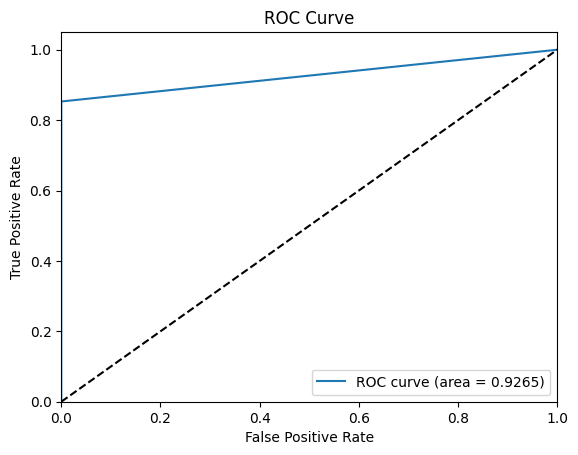

In [ ]:
y_true = conversations_df['mode_change_binary']
y_pred = df_predictions['change_of_venue']
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()